In [2]:
import sys
import os
import pickle
import numpy as np
from sklearn.model_selection import KFold
from sklearn import model_selection,preprocessing
from keras.utils import np_utils
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam 
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from dataset import Dataset
from database import Database
from sample import Sample

gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [3]:
dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
my_database = Database(dataset_loc, database_loc, site)
my_dataset = Dataset(dataset_loc, site, ext='.vr2')

In [4]:
_ = my_database.stats(test=False, img=True)
_ = my_database.stats(test=True, img=True)

100%|██████████| 18086/18086 [00:02<00:00, 7649.13it/s]



Database statistics               
min                   0           
max                   255         
mean                  121.931     
std                   26.419      
noise                 9768[54.01%]
whistler              8318[45.99%]
total                 18086       



100%|██████████| 8918/8918 [00:01<00:00, 7378.70it/s]



Database statistics               
min                   0           
max                   255         
mean                  121.472     
std                   26.573      
noise                 4781[53.61%]
whistler              4137[46.39%]
total                 8918        



In [16]:
def load_dataset(verbose=True):
    # load dataset
    trainX, trainY = my_database.load_cuts_img_db_mp(test=False)
    # reshape dataset
    trainX = trainX.reshape((trainX.shape[0],trainX.shape[1],trainX.shape[2],1))
    trainY = np_utils.to_categorical(trainY)
    if verbose:
        # summarise loaded dataset
        print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
        # plot few images
        plt.figure(figsize=(20,15))
        for ix in range(5*5):
            plt.subplot(5,5,1+ix)
            plt.imshow(trainX[np.random.randint(len(trainX)),:,:,0], cmap=plt.get_cmap('jet'))
        plt.show()
    return trainX, trainY

# scale pixels
def prep_pixels(train):
    # convert from integers to floats
    train_norm = train.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    # return normalized images
    return train_norm

def define_model(width, height):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(width, height, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.7))
    model.add(Conv2D(2, (11, 11), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.7))
    model.add(Dense(2, activation='softmax'))
    # compile model
    epochs = 25
    lrate = 0.0001
    decay = lrate/epochs
    opt = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(model, dataX, dataY, n_folds=3):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), verbose=1)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(211)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(212)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['acc'], color='blue', label='train')
        plt.plot(histories[i].history['val_acc'], color='orange', label='test')
    plt.show()

# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()
    
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY = load_dataset()
    # prepare pixel data
    trainX = prep_pixels(trainX)
    # define model
    model = define_model(trainX.shape[1],trainX.shape[2])
    # evaluate model
    scores, histories = evaluate_model(model, trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)
    return model, scores, histories
    
def model_get_conv_layers(model):
    layers = []
    # summarize filter shapes
    for layer in model.layers:
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        # get filter weights
        layers.append(layer)
    return layers

def model_visualization(model, summary=False, plot=False, conv_layer_number=0):
    '''Visualize the CNN model'''
    if summary:
        print(model.summary())
    if plot:
        plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
        Image(retina=True, filename='model.png')
    # get filers and biases
    filters, biases = model_get_conv_layers(model)[conv_layer_number].get_weights()
    # scale filters
    f_min, f_max = filters.min(), filters.max()
    filters = (filters-f_min)/(f_max-f_min)
    # get number of filters
    n_filters, ix = filters.shape[-1], 1
    
    plt.figure(figsize=(n_filters,1))
    for i in range(n_filters):
        # get the filters
        f = filters[:,:,:,i]
        # plot each channel seperately
        for j in range(1):
            # specify subplot and turn of axis
            ax = plt.subplot(1,n_filters, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='jet')
            ix += 1
    plt.show()
    
def model_visualization_fm(model, data, conv_layer_number=0):
    feature_maps = model.predict(data)
    for i in range(n_filters):
        # get the filters
        f = filters[:,:,:,i]
        # plot each channel seperately
        for j in range(1):
            # specify subplot and turn of axis
            ax = plt.subplot(1,n_filters, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.pcolormesh(f[:, :, j], cmap='jet')
            ix += 1
    plt.show()

100%|██████████| 18086/18086 [00:02<00:00, 7475.81it/s]


Train: X=(18086, 128, 207, 1), y=(18086, 2)


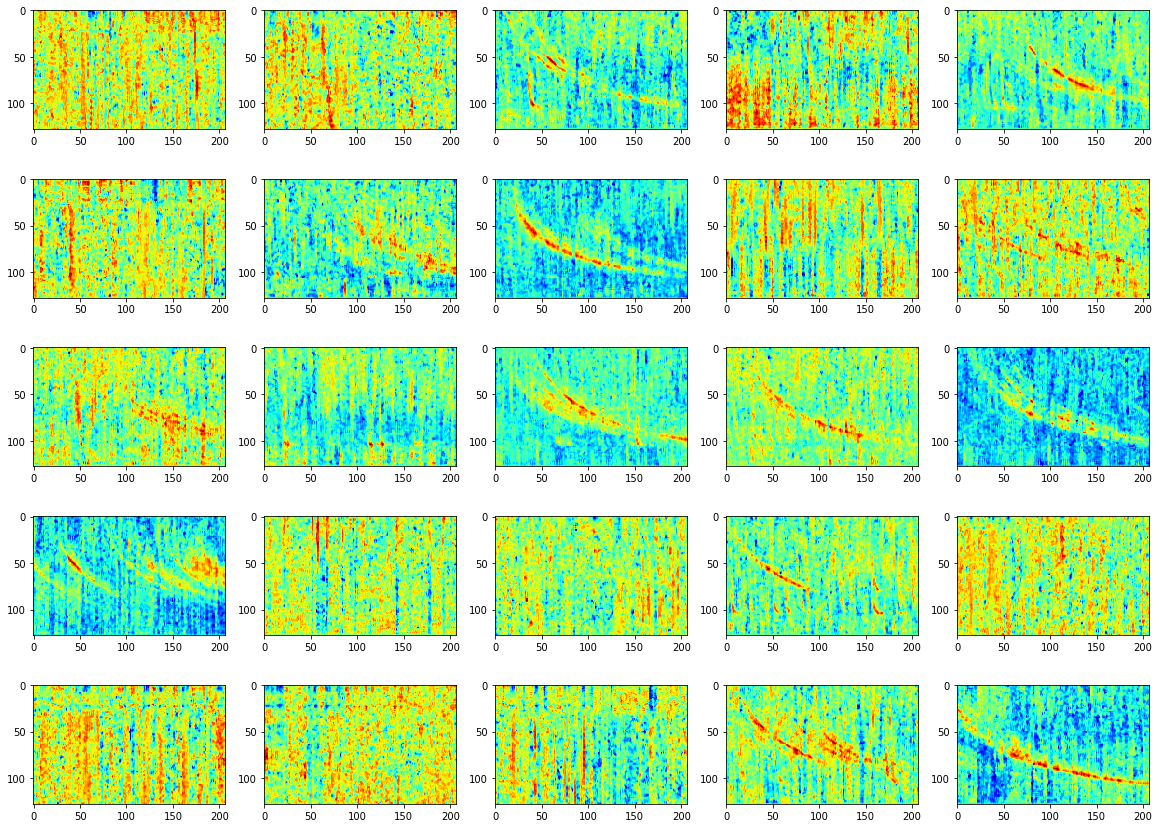

Train on 12057 samples, validate on 6029 samples
Epoch 1/20
12057/12057 [==============================] - 46s 4ms/step - loss: 0.7245 - acc: 0.7549 - val_loss: 0.7327 - val_acc: 0.8149
Epoch 2/20
12057/12057 [==============================] - 46s 4ms/step - loss: 0.3500 - acc: 0.8864 - val_loss: 0.5888 - val_acc: 0.8414
Epoch 3/20
12057/12057 [==============================] - 46s 4ms/step - loss: 0.2341 - acc: 0.9223 - val_loss: 0.4629 - val_acc: 0.8698
Epoch 4/20
12057/12057 [==============================] - 46s 4ms/step - loss: 0.2145 - acc: 0.9319 - val_loss: 0.3479 - val_acc: 0.8977
Epoch 5/20
12057/12057 [==============================] - 46s 4ms/step - loss: 0.1778 - acc: 0.9405 - val_loss: 0.2610 - val_acc: 0.9202
Epoch 6/20
12057/12057 [==============================] - 46s 4ms/step - loss: 0.1575 - acc: 0.9475 - val_loss: 0.2294 - val_acc: 0.9307
Epoch 7/20
12057/12057 [==============================] - 46s 4ms/step - loss: 0.1362 - acc: 0.9570 - val_loss: 0.1542 - val_acc:

/home/othniel/anaconda3/envs/dp_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/othniel/anaconda3/envs/dp_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


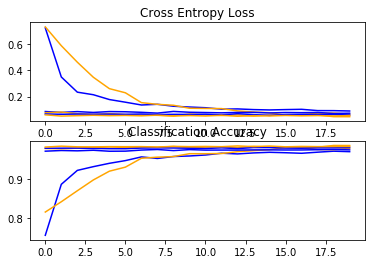

Accuracy: mean=98.308 std=0.310, n=3


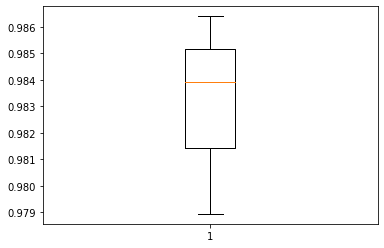

In [17]:
model, scores, histories = run_test_harness()
# save model
model.save('final_model.h5')

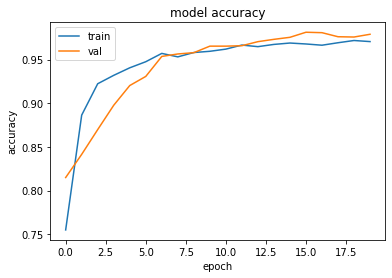

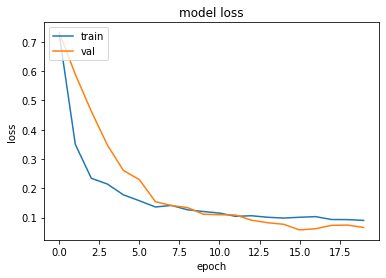

In [18]:
history = histories[0]
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

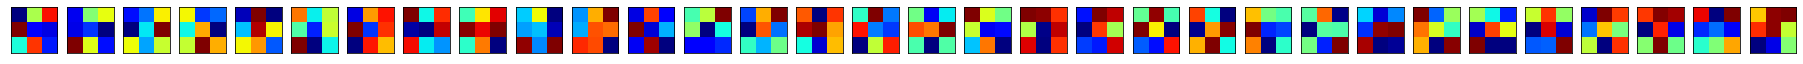

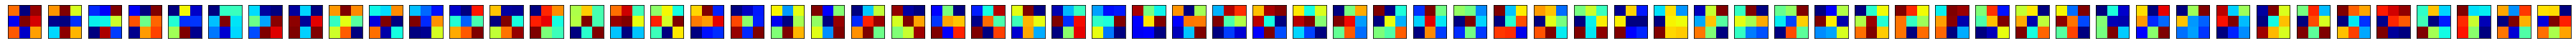

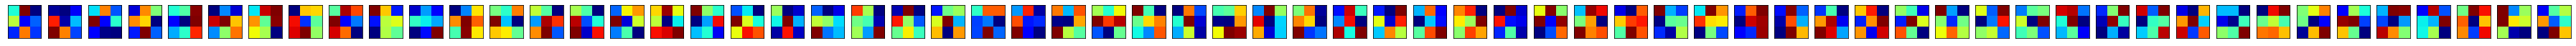

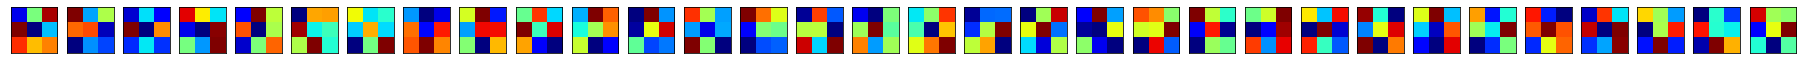

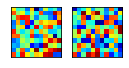

In [19]:
for ix in range(len(model_get_conv_layers(model))):
    model_visualization(model, conv_layer_number=ix)

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 126, 205, 32)      320       
_________________________________________________________________
batch_normalization_19 (Batc (None, 126, 205, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 102, 32)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 61, 100, 64)       18496     
_________________________________________________________________
batch_normalization_20 (Batc (None, 61, 100, 64)       256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 61, 100, 64)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 59, 98, 64)        36928     
__________

2013-07-20UT16:12:40.04451914.marion.vr2


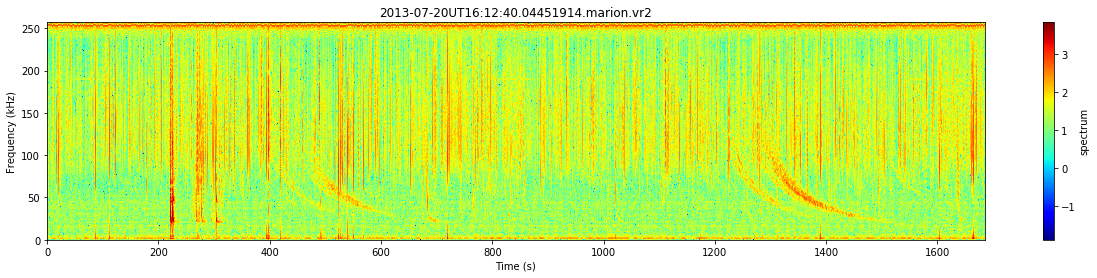

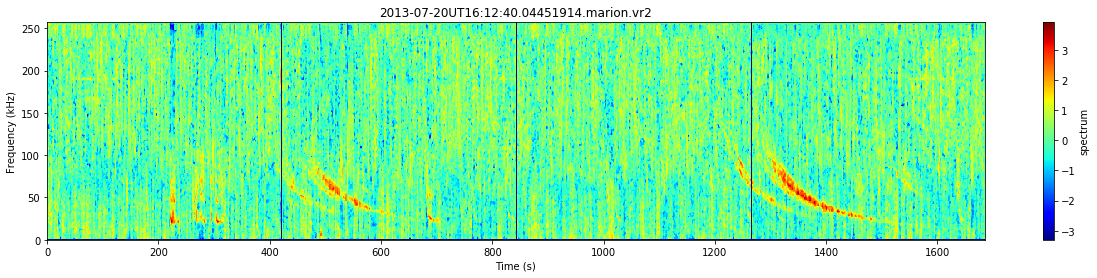

/home/othniel/anaconda3/envs/dp_gpu/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/othniel/anaconda3/envs/dp_gpu/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/othniel/anaconda3/envs/dp_gpu/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/othniel/anaconda3/envs/dp_gpu/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


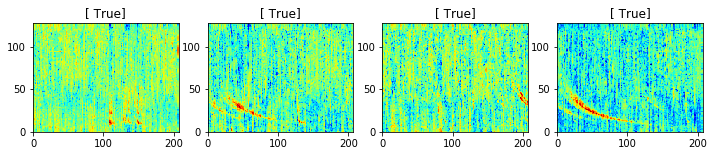

In [28]:
my_dataset = Dataset(dataset_loc, site)
my_sample = Sample(dataset_loc, site, my_dataset.get_random_sample())

my_sample = Sample(dataset_loc, site, '2013-06-25UT15:57:59.60931922.marion.vr2')
my_sample = Sample(dataset_loc, site, '2013-07-20UT16:12:40.04451914.marion.vr2')
print(my_sample.get_file())
size=(21,4)
cmap='jet'

# plot new spec
# print(cuts[0][1]-cuts[0][0],cuts[0][3]-cuts[0][2])

my_sample.spectrogram_plot(figsize=size, xaxis=None, yaxis=None, xlabel='Time (s)', ylabel='Frequency (kHz)', title=my_sample.get_file())

my_sample.apply_zscore()
my_sample.apply_medfilt(kernel=(3,3))
# my_sample.apply_min_max_scale(0,1)
width, height = 4, 1

spec, cuts, indice = my_sample.split(width, height, shape=(207,128))
my_sample.spectrogram_plot(figsize=size, spec=spec, xaxis=None, yaxis=None, xlabel='Time (s)', ylabel='Frequency (kHz)', title=my_sample.get_file())
model = load_model('final_model.h5')
# plt.figure(figsize=(width*2, height*2))
# for ix,cut in enumerate(cuts):
#     plt.subplot(1,width,ix+1)
#     plt.pcolormesh(cut, cmap=cmap)
# plt.show()
    
plt.figure(figsize=(width*3, height*2))
for ix,cut in enumerate(cuts):
    plt.subplot(1,width,ix+1)
    plt.pcolormesh(cut, cmap=cmap)
    cut =  preprocessing.MinMaxScaler(feature_range=(0, 0.99)).fit_transform(cut)
    plt.title(np.bool_(model.predict_classes(cut.T.reshape((1,cut.shape[0],cut.shape[1],1)))))
plt.show()
    